# E-commerce purchase prediction

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, f1_score, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV


In [3]:
df = pd.read_csv('ecommerce_behavior.csv')

df['view_to_cart_ratio'] = df['cart_adds'] / (df['views'] + 1)
df['price_discounted'] = df['price'] * (1 - df['discount'])
df['expensive'] = (df['price'] > 500).astype(str)
df['is_mobile'] = (df['device'] == 'Mobile').astype(str)

In [4]:
df.describe()

,price,discount,views,cart_adds,rating,purchased,view_to_cart_ratio,price_discounted
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,493.200916,0.251898,2.991200,0.911000,3.748300,0.319800,0.206754,369.442563
std,287.392505,0.144912,1.731162,0.959616,0.715083,0.466446,0.203874,231.930928
min,5.010000,0.000000,0.000000,0.000000,2.500000,0.000000,0.000000,2.754000
25%,239.292500,0.130000,2.000000,0.000000,3.100000,0.000000,0.000000,173.981425
50%,490.775000,0.250000,3.000000,1.000000,3.700000,0.000000,0.200000,350.687600
75%,739.932500,0.380000,4.000000,1.000000,4.400000,1.000000,0.333333,531.272750
max,999.520000,0.500000,11.000000,7.000000,5.000000,1.000000,0.857143,978.314400


In [5]:
# Here we see that dataset is imbalanced
df['purchased'].value_counts(normalize=True)

purchased
0    0.6802
1    0.3198
Name: proportion, dtype: float64

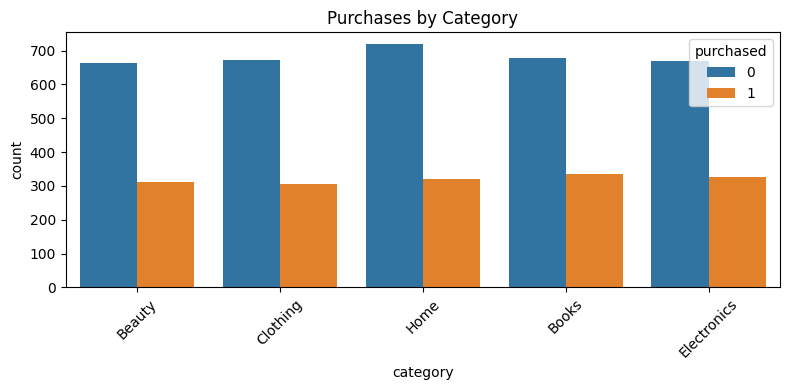

In [6]:
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x="category", hue="purchased")
plt.title("Purchases by Category")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


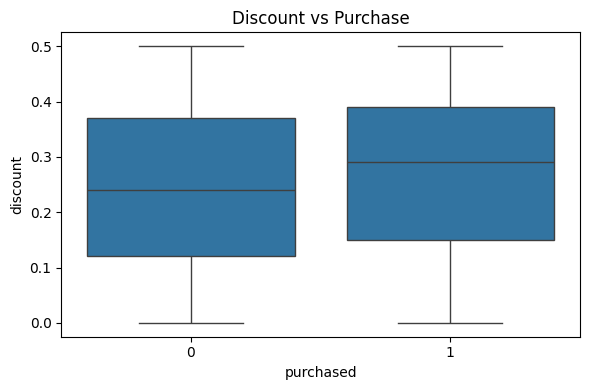

In [7]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=df, x="purchased", y="discount")
plt.title("Discount vs Purchase")
plt.tight_layout()
plt.show()

In [8]:
X = df.drop('purchased', axis=1)
y = df['purchased']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [9]:
num_features = X.select_dtypes(include=['int64','float64']).columns
cat_features = X.select_dtypes(include=['object']).columns

num_transformer_poly = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Creating preprocessor for Logistic Regression with PolymonailFeatures
preprocessor_with_poly = ColumnTransformer(transformers=[
    ('num', num_transformer_poly, num_features),
    ('cat', cat_transformer, cat_features)
])


num_transformer_plain = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# Creating preprocessor for other models without PolymonailFeatures
preprocessor_no_poly = ColumnTransformer(transformers=[
    ('num', num_transformer_plain, num_features),
    ('cat', cat_transformer, cat_features)
])


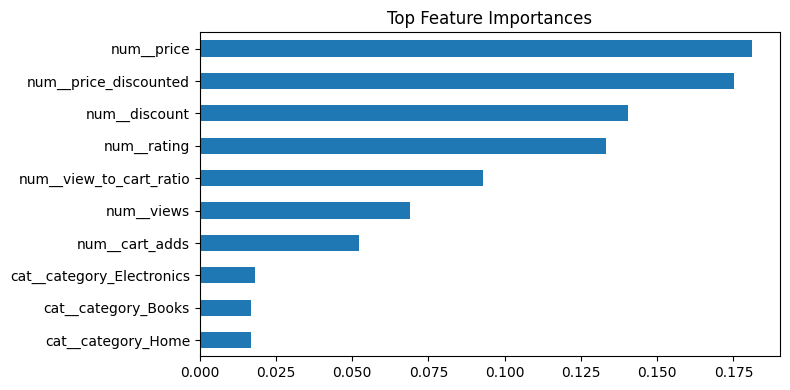

In [10]:


rf = Pipeline([
    ('preprocessor', preprocessor_no_poly),
    ('classifier', RandomForestClassifier(random_state=42))
])
rf.fit(X_train, y_train)

importances = rf.named_steps['classifier'].feature_importances_
feature_names = rf.named_steps['preprocessor'].get_feature_names_out()
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:10]

plt.figure(figsize=(8, 4))
feat_imp.plot(kind='barh')
plt.title("Top Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [11]:
# Searching for the best parameters for Log Regression
param_grid_log_reg = {
    'classifier__C': [0.01, 0.1, 0.3, 0.5, 0.8, 1, 10],
    'classifier__penalty': ['l1', 'l2']
}

# Searching for the best parameters for Random Forest
param_grid_rf = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [1, 3]
}

# Searching for the best parameters for XGBoost
param_grid_xgb = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 6],
    'classifier__learning_rate': [0.01, 0.1],
    'classifier__subsample': [0.8, 1.0]
}

In [12]:
result = []
def build_model(model, preprocessor, param_grid, X_train, y_train):
    pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
    ])

    grid_search = GridSearchCV(
        pipe,
        param_grid,
        cv=5,
        scoring='roc_auc',
        verbose=1,
        n_jobs=-1
    )

    grid_search.fit(X_train, y_train)
    best_model = grid_search.best_estimator_
    return best_model

def eval_model(best_model, X_test, y_test, result):
    
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]
    
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    result.append({
        'model_name': best_model.named_steps['classifier'].__class__.__name__,
        'y_pred': y_pred,
        'y_proba': y_proba,
        'f1_score': round(f1, 3),
        'roc_auc':round(roc_auc, 3)
    }
    )

    return result
    

In [13]:
log_reg = build_model(LogisticRegression(solver='liblinear'), preprocessor_with_poly, param_grid_log_reg, X_train, y_train)
result = eval_model(log_reg, X_test, y_test, result)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


In [14]:
rand_forest = build_model(RandomForestClassifier(random_state=42), preprocessor_with_poly, param_grid_rf, X_train, y_train)
result = eval_model(rand_forest, X_test, y_test, result)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


In [15]:
xgb = build_model(XGBClassifier(eval_metric='logloss'), preprocessor_with_poly, param_grid_xgb, X_train, y_train)
result = eval_model(xgb, X_test, y_test, result)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [16]:
pd.DataFrame(result)[['model_name', 'f1_score', 'roc_auc']]

,model_name,f1_score,roc_auc
0,LogisticRegression,0.320,0.707
1,RandomForestClassifier,0.292,0.718
2,XGBClassifier,0.250,0.720


In [17]:
log_entry = next(item for item in result if item['model_name'] == 'LogisticRegression')

y_proba = log_entry['y_proba']
y_pred = log_entry['y_pred']

**Logistic Regression shows the best result based on the evaluation. ROC AUC 0.7 means that the model distinguishes well between users who make purchases and** 
**those who do not.**
**Considering that the data is unbalanced, F1 shows an acceptable result. The model correctly guesses 1 out of 3.**

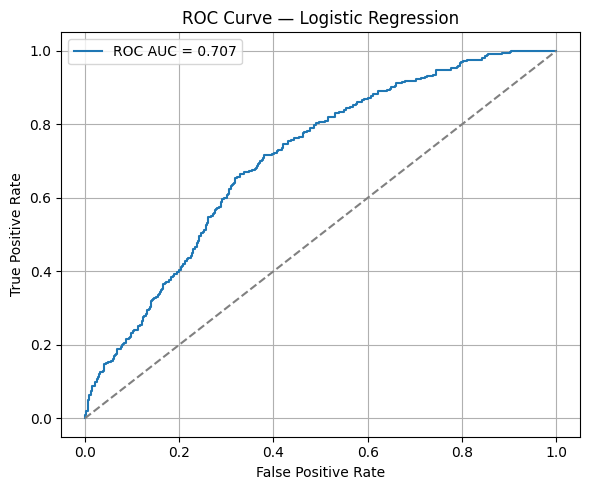

In [18]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test, y_proba):.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Logistic Regression")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

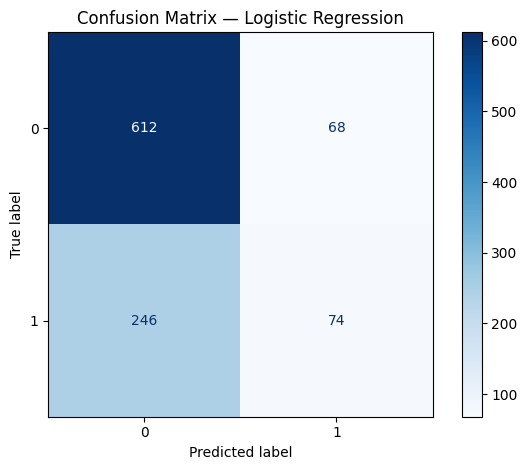

In [19]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix — Logistic Regression")
plt.grid(False)
plt.tight_layout()
plt.show()